# GAN

### GAN (DCGAN)을 이용해서 MNIST 패션 이미지를 생성하세요. 
* GAN은 분류모형에 비해 학습이 까다롭습니다. 모형과 파라미터를 세심하게 잘 설정하시기 바랍니다.

원데이터와 확률분포를 정확히 공유하는 데이터를 생성하는 방법

In [ ]:
from tensorflow import keras
from keras import models 
from keras import layers
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from keras.utils import to_categorical
from keras.datasets import fashion_mnist
import tensorflow as tf
from tqdm.autonotebook import tqdm
%matplotlib inline
from IPython import display


In [ ]:
pip install --upgrade tensorflow

Requirement already up-to-date: tensorflow in /usr/local/lib/python3.6/dist-packages (2.4.0)


패션 mnist 를 불러오고 패션 이미지의 훈련셋과 트레이닝 셋을 28x28로 나눕니다.

In [ ]:
(train_images, _), (test_images, _) = tf.keras.datasets.fashion_mnist.load_data()
train_images = train_images.reshape(train_images.shape[0], 28, 28, 1).astype("float32") / 255.0
test_images = test_images.reshape(test_images.shape[0], 28, 28, 1).astype("float32") / 255.0

train_dataset = (tf.data.Dataset.from_tensor_slices(train_images).shuffle(20000).batch(128))
test_dataset = (tf.data.Dataset.from_tensor_slices(test_images).shuffle(5000).batch(128))

In [ ]:
class GAN(tf.keras.Model):
    def __init__(s, **kwargs):
        super(GAN, s).__init__()
        s.__dict__.update(kwargs)
        s.gen = tf.keras.Sequential(s.gen)
        s.disc = tf.keras.Sequential(s.disc)

    def generate(s, z):
        return s.gen(z)
   
    def discriminate(s, x):
        return s.disc(x)

    def compute_loss(s, x):
        z_samp = tf.random.normal([x.shape[0], 1, 1, s.n_Z])
        x_gen = s.generate(z_samp)
        logits_x = s.discriminate(x)
        logits_x_gen = s.discriminate(x_gen)
        disc_real_loss = gan_loss(logits=logits_x, is_real=True)
        disc_fake_loss = gan_loss(logits=logits_x_gen, is_real=False)
        disc_loss = disc_fake_loss + disc_real_loss
        gen_loss = gan_loss(logits=logits_x_gen, is_real=True)
        return disc_loss, gen_loss

    def compute_gradients(s, x):
        with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
            disc_loss, gen_loss = s.compute_loss(x)
        gen_gradients = gen_tape.gradient(gen_loss, s.gen.trainable_variables)
        disc_gradients = disc_tape.gradient(disc_loss, s.disc.trainable_variables)
        return gen_gradients, disc_gradients

    def apply_gradients(s, gen_gradients, disc_gradients):
        s.gen_optimizer.apply_gradients(zip(gen_gradients, s.gen.trainable_variables))
        s.disc_optimizer.apply_gradients(zip(disc_gradients, s.disc.trainable_variables))
   
    def train(s, train_x):
        gen_gradients, disc_gradients = s.compute_gradients(train_x)
        s.apply_gradients(gen_gradients, disc_gradients)
        
def gan_loss(logits, is_real=True):
    if is_real: labels = tf.ones_like(logits)
    else:labels = tf.zeros_like(logits)
    return tf.compat.v1.losses.sigmoid_cross_entropy(multi_class_labels=labels, logits=logits)


In [ ]:
gen = [tf.keras.layers.Dense(units=7 * 7 * 64, activation="relu"), tf.keras.layers.Reshape(target_shape=(7, 7, 64)),
             tf.keras.layers.Conv2DTranspose(filters=64, kernel_size=3, strides=(2, 2), padding="SAME", activation="relu"),
             tf.keras.layers.Conv2DTranspose(filters=32, kernel_size=3, strides=(2, 2), padding="SAME", activation="relu"),
    tf.keras.layers.Conv2DTranspose(filters=1, kernel_size=3, strides=(1, 1), padding="SAME", activation="sigmoid"),]


In [ ]:
disc = [tf.keras.layers.InputLayer(input_shape=(28,28,1)),
    tf.keras.layers.Conv2D(filters=32, kernel_size=3, strides=(2, 2), activation="relu"),
    tf.keras.layers.Conv2D(filters=64, kernel_size=3, strides=(2, 2), activation="relu"),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(units=1, activation=None),]

In [ ]:
model = GAN(gen = gen,disc = disc,gen_optimizer = gen_optimizer,disc_optimizer = disc_optimizer,n_Z= 64)

In [ ]:
def plot_reconstruction(model, nex=8, zm=2):
    samples = model.generate(tf.random.normal(shape=(128, N_Z)))
    fig, axs = plt.subplots(ncols=nex, nrows=1, figsize=(zm * nex, zm))
    for axi in range(nex):
        axs[axi].matshow(samples.numpy()[axi].squeeze(), cmap=plt.cm.Greys, vmin=0, vmax=1)
        axs[axi].axis('off')
    plt.show()

In [ ]:
losses = pd.DataFrame(columns = ['disc_loss', 'gen_loss'])

Epoch: 15 | disc_loss: 0.6404908299446106 | gen_loss: 1.5145890712738037


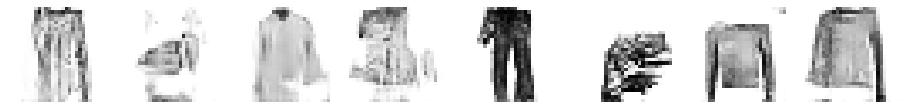

In [ ]:
n_epochs = 16
for epoch in range(n_epochs):
    for batch, train_x in tqdm(zip(range(int(20000/128)), train_dataset), total=int(20000/128)):
        model.train(train_x)
    loss = []
    for batch, test_x in tqdm(
        zip(range(int(5000/128)), test_dataset), total=int(5000/128)
    ):
        loss.append(model.compute_loss(train_x))
    losses.loc[len(losses)] = np.mean(loss, axis=0)
    display.clear_output()
    print("Epoch: {} | disc_loss: {} | gen_loss: {}".format(epoch, losses.disc_loss.values[-1], losses.gen_loss.values[-1]))
    plot_reconstruction(model)

참조

https://dreamgonfly.github.io/blog/gan-explained/

https://colab.research.google.com/github/timsainb/tensorflow2-generative-models/blob/master/2.0-GAN-fashion-mnist.ipynb#scrollTo=Pqnns6X2CV-U